In [1]:
from plot_decision_regions import plot_decision_regions
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('biolog.csv')
df['1'] = np.where(df['1']=='M', 1, 0) # class name
X, y =  df.drop(['0', '1'], axis=1), df[['1']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

<img src='https://user-images.githubusercontent.com/54672403/82236109-4f8dc500-993c-11ea-9941-6193fd9a4d6c.png' width='500'>

In [3]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=42),)

In [4]:
pipe_lr.fit(X_train, y_train)
pipe_lr.score(X_test, y_test)

0.9473684210526315

# Алгоритмы оценки производительности модели:
##  Перекрёсная проверка с удежанием (holdout)
> **Недостаток:** чувствителен к способу разбиения на обучающие и проверочные поднаборы
<img src='http://www.cs.nthu.edu.tw/~shwu/courses/ml/labs/08_CV_Ensembling/fig-holdout.png' width='400'>
##  Перекрёсная проверка по k блокам (K-fold)
<img src='https://pbs.twimg.com/media/EFXQhZ1VUAEfwWM.jpg' width='600'>



In [5]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, random_state=42).split(X_train, y_train)
scores = []
for  k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train.iloc[train], y_train.iloc[train])
    score = pipe_lr.score(X_train.iloc[test], y_train.iloc[test])
    scores.append(score)
    print(f'{k+1} Размер наборa (train, test) = {y_train.iloc[train].size, y_train.iloc[test].size} результат: {score:.3} ')

print(f'Итог: результат K-folders = {np.mean(scores):.2} ±{np.std(scores):.2}')

1 Размер наборa (train, test) = (364, 91) результат: 0.934 
2 Размер наборa (train, test) = (364, 91) результат: 0.989 
3 Размер наборa (train, test) = (364, 91) результат: 0.923 
4 Размер наборa (train, test) = (364, 91) результат: 0.945 
5 Размер наборa (train, test) = (364, 91) результат: 0.956 
Итог: результат K-folders = 0.95 ±0.023


In [6]:
from sklearn.model_selection import learning_curve
def Learning_curve_model(X, Y, model, cv, train_sizes):
    plt.title("Learning curve")
    plt.xlabel("Количество обучающих образцов")
    plt.ylabel("Результат")
    plt.grid()

    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Правильность при обучение")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Правильность при проверке")
                     
    plt.legend(loc="lover right")

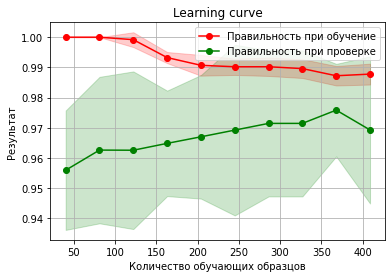

In [7]:
pipe_lr_2 = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=1))
Learning_curve_model(X_train, y_train, model= pipe_lr_2, cv= 10, train_sizes= np.linspace(0.1, 1, 10));

- модель работает хорошо, если во время обучения она встречает более 200 образцов, а если меньше, то разрыв между результатами увеличивается

In [8]:
from sklearn.model_selection import validation_curve
def Validation_curve_model(X, Y, model, cv, param_name, param_range):
    plt.title("Validation curve")
    plt.xlabel("Параметр С")
    plt.ylabel("Результат")
    plt.grid()

    train_scores, test_scores = validation_curve(model, X, Y, cv=cv, n_jobs=-1, param_name=param_name, param_range=param_range)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.semilogx(param_range, train_scores_mean, 'o-', color="r", label="Правильность при обучение")
    plt.semilogx(param_range, test_scores_mean, 'o-', color="g", label="Правильность при проверке")
                     
    plt.legend(loc="lover right")

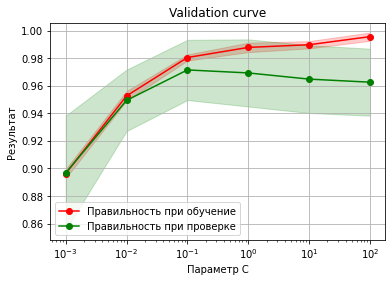

In [9]:
Validation_curve_model(X_train, y_train, model= pipe_lr_2, 
                       cv= 10,param_range=[.001, .01, .1, 1, 10, 100],param_name='logisticregression__C' );

# Решётчатый поиск (Grid search)

In [10]:
from sklearn.model_selection import GridSearchCV
def grid_search_model(X, Y, model, parameters, cv):
    CV_model = GridSearchCV(estimator=model, param_grid=parameters, cv=cv, n_jobs=-1, scoring='accuracy')
    CV_model.fit(X, Y)
    print(f"Best Score: {CV_model.best_score_:.3}\nBest parameters: {CV_model.best_params_}")
    #CV_model.cv_results_ - all results

In [11]:
from sklearn.svm import SVC    
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=42))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

grid_search_model(X_train, y_train, model=pipe_svc, parameters=param_grid, cv=10)

Best Score: 0.976
Best parameters: {'svc__C': 100.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [12]:
from sklearn.model_selection import RandomizedSearchCV
# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(pipe_svc, param_distributions=param_grid, n_iter=20)
random_search.fit(X_train, y_train)
print(f"Best Score: {random_search.best_score_:.3}\nBest parameters: {random_search.best_params_}")

Best Score: 0.969
Best parameters: {'svc__kernel': 'rbf', 'svc__gamma': 0.0001, 'svc__C': 1000.0}


# Вложенная перекрёсная проверка
> Поможет в отборе алгоритмов, показывая эффективность

<img src='https://forums.fast.ai/uploads/default/original/3X/f/d/fd1d8ae2573d567162c241e8c84a9f2ca399be00.png' width='400'>

In [13]:
from sklearn.model_selection import cross_val_score

CV_model = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, cv=2, n_jobs=-1, scoring='accuracy')
score = cross_val_score(estimator=CV_model,X=X_train, y=y_train, cv=5, n_jobs=-1, scoring='accuracy')
print(f'Результат перерекрёстной проверки = {np.mean(scores):.2} ±{np.std(scores):.2}')

Результат перерекрёстной проверки = 0.95 ±0.023


In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

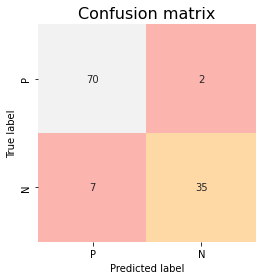

In [15]:
mtrx_df  = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['P','N'], index=['P','N'])
fig=sns.heatmap(mtrx_df, annot=True, cmap='Pastel1', square=True, cbar=False)
plt.title('Confusion matrix', size=16)
plt.ylabel('True label')
plt.xlabel('Predicted label');

- Модель классифицировала `7` поциентов как больных  **(FalsePositive)**, хотя они здоровы, <br>и `2`  больных определила в здоровых  **(FalseNegative)**
<img src='https://i0.wp.com/flowingdata.com/wp-content/uploads/2014/05/Type-I-and-II-errors1.jpg?fit=960%2C720&amp;ssl=1' width='400'>

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.946
Recall: 0.833
F1: 0.886


# Меняем Scoring
$F1 = 2*\frac{PRE*REC}{PRE+REC}$

In [17]:
from sklearn.metrics import precision_score,f1_score, make_scorer
scorer = make_scorer(precision_score, pos_label=0) # в sklearn положительный класс 1, а у нас - 0
CV_model2 = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer)

## Receiver Operating Characteristic ROC
—  помогает в отборе классификаторов, основываясь на их эффективности относительно ***PRE, REC***
<br>***диагональ roc*** — это рандом, если классификатор ниже диагонали, он говно
<br>***ROC AUC*** —  площадь под кривой, помогает узнать эффективность классификатора


In [18]:
from sklearn.metrics import roc_curve, auc
def drow_roc(y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc= auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange',
              label='ROC curve (area = %0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")


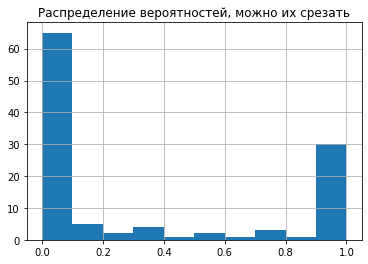

'PRE= 0.97 REC= 0.81'

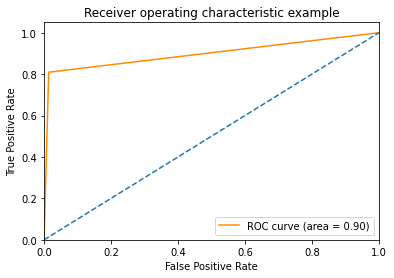

In [19]:
y_predicted_prob = lr.predict_proba(X_test)
pd.Series(y_predicted_prob[:, 1]).hist()
plt.title('Распределение вероятностей, можно их срезать')
plt.show()
y_pred2 = np.where(y_predicted_prob[:, 1]>0.6, 1, 0)
drow_roc(y_pred2)
f'PRE= {precision_score(y_test, y_pred2):.2} REC= {recall_score(y_test, y_pred2):.2}'

In [20]:
def model_roc_auc(model,):
    fig = plt.figure(figsize=(7, 5))
    all_roc_auc = []
    X_train2 = X_train.iloc[:, [4, 14]]
    
    kfold = list(StratifiedKFold(n_splits=5).split(X_train, y_train))
    for i, (train, test) in enumerate(kfold):
        probas = model.fit(X_train2.iloc[train],
                        y_train.iloc[train]).predict_proba(X_train2.iloc[test])

        fpr, tpr, thresholds = roc_curve(y_train.iloc[test], probas[:, 1], pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC кривая блока {i+1} (площадь = {roc_auc:.2})')
        all_roc_auc.append(roc_auc)

    plt.plot([0, 1],[0, 1],linestyle='--',color='gray', label='Рандом')
    plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='Идеальная эффективность')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend(loc="lower right");
    print('[*] Средняя площадь ROC =', np.mean(all_roc_auc))

[*] Средняя площадь ROC = 0.7736842105263158


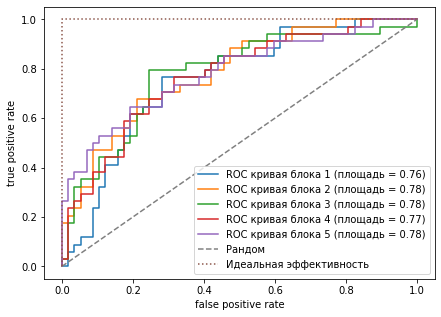

In [21]:
model_roc_auc(pipe_lr)

# Работа с несбалансированными классами


In [22]:
y_np = y.values
X_imb = np.vstack((X[y_np == 0], X[y_np == 1][:40]))
y_imb = np.hstack((y_np[y_np == 0], y_np[y_np == 1][:40]))

In [23]:
y_pred = np.zeros(y_imb.shape[0])
print(f"Ситуация дисбаланса: при выборе только 1 класса получим вероятность ~ {np.mean(y_pred == y_imb):.0%}")

Ситуация дисбаланса: при выборе только 1 класса получим вероятность ~ 90%


In [24]:
from sklearn.utils import resample
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=42)
print('Новый размер миноритарного класса = мажоритарному = ', len(X_upsampled))

Новый размер миноритарного класса = мажоритарному =  357


In [25]:
X_balanced = np.vstack((X[y_np == 0], X_upsampled))
y_balanced = np.hstack((y_np[y_np == 0], y_upsampled))

# Ансамблевые методы
**Цель:** объеденить классификаторы в *мегаклассификатор*, который даёт улучшенные прогнозы 



In [26]:
from sklearn import datasets
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test =train_test_split(X, y,  test_size=0.5,  random_state=1, stratify=y)

In [27]:
np.argmax( np.bincount([0,0,1], weights=[.2, .2, .6]))

1

In [28]:
# p_a = sum(x * weights) / sum(weights)
p = [[.8, .5], [.9, .2], [.5, .2]]
p_a = np.average(p, axis=0, weights=[.2, .2, .9])
np.argmax(p_a)

0

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline


clf1 = LogisticRegression(penalty='l2', C=0.001,random_state=42)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=42)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

In [30]:
def print_auc(all_clf, clf_labels):
    print('Перекрестная проверка по 10 блокам :\n')
    for clf, label in zip(all_clf, clf_labels):
        scores = cross_val_score(estimator=clf,
                                 X=X_train, y=y_train,
                                 cv=10, scoring='roc_auc')
        print(f"ROC AUC: {scores.mean():.2%} ±{scores.std():.2} ({label})")

print_auc([pipe1, clf2, pipe3], clf_labels)

Перекрестная проверка по 10 блокам :

ROC AUC: 91.67% ±0.15 (Logistic regression)
ROC AUC: 86.67% ±0.18 (Decision tree)
ROC AUC: 85.00% ±0.13 (KNN)


In [31]:
from MajorityVoteClf import MajorityVoteClf
mega_clf = MajorityVoteClf(classifiers=[pipe1, clf2, pipe3])

print_auc([mega_clf], ['Мега классификатор'])

Перекрестная проверка по 10 блокам :

ROC AUC: 98.33% ±0.05 (Мега классификатор)


In [32]:
def drow_many_roc(all_clf, clf_labels):
    fig = plt.figure(figsize=(9, 7))
    colors = ['black', 'orange', 'blue', 'green']
    linestyles = [':', '--', '-.', '-']
    for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):

        y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
        roc_auc = auc(x=fpr, y=tpr)
        plt.plot(fpr, tpr, label=f'ROC кривая {label} (площадь = {roc_auc:.2})')
        

    plt.legend(loc='lower right')
    plt.plot([0, 1],[0, 1],linestyle='--',color='gray')
    plt.grid(alpha=0.5)
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)');

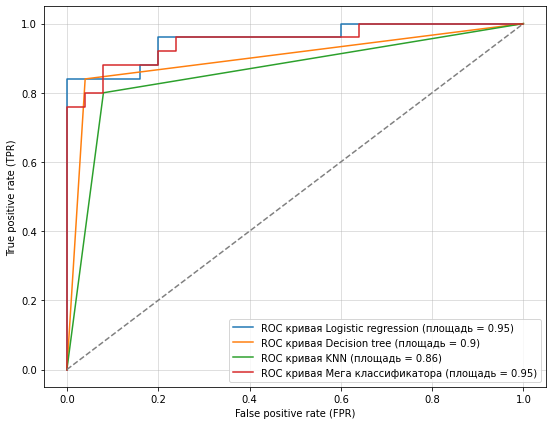

In [33]:
drow_many_roc([pipe1, clf2, pipe3, mega_clf], clf_labels+['Мега классификатора'])

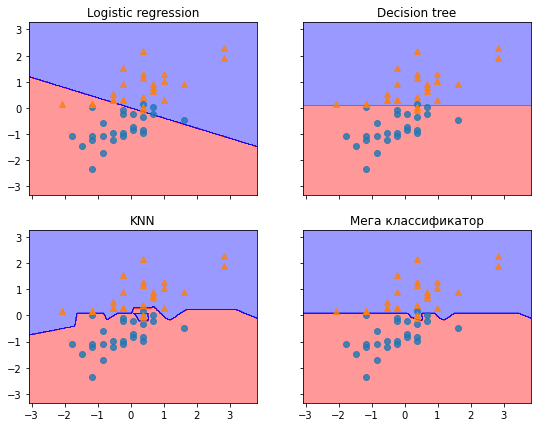

In [34]:
from itertools import product
all_clf = [pipe1, clf2, pipe3, mega_clf]

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

_, ax = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(9, 7))
for idx, clf, label in zip(product([0, 1], [0, 1]), all_clf, clf_labels+['Мега классификатор']):
    clf.fit(X_train_std, y_train)
    plot_decision_regions(X_train_std, y_train, clf, label, ax= ax[idx[0], idx[1]])

## - Применение решётчатого поиска 

In [35]:
# Можно посмотреть названия параметров 
# mega_clf.get_params()

In [36]:
params = {'decisiontreeclassifier__max_depth': [1, 3, 5],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mega_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f ± %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

print(f'\nЛучшие параметры: {grid.best_params_:}')
print(f'Результат: {grid.best_score_:.2}')

0.983 ± 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 ± 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 ± 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 ± 0.02 {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 0.001}
0.983 ± 0.02 {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 0.1}
0.967 ± 0.05 {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 100.0}
0.983 ± 0.02 {'decisiontreeclassifier__max_depth': 5, 'pipeline-1__clf__C': 0.001}
0.983 ± 0.02 {'decisiontreeclassifier__max_depth': 5, 'pipeline-1__clf__C': 0.1}
0.967 ± 0.05 {'decisiontreeclassifier__max_depth': 5, 'pipeline-1__clf__C': 100.0}

Лучшие параметры: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
Результат: 0.98


In [37]:
mega_clf.set_params(**grid.best_estimator_.get_params());

#  Стекинг
<img src='https://user-images.githubusercontent.com/54672403/82154626-d036bd80-9877-11ea-9e10-563a2618aad4.png' width='500'>

In [38]:
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingCVClassifier
lr = LogisticRegression()
sclf = StackingCVClassifier(classifiers=[pipe1, clf2, pipe3], meta_classifier=lr, random_state=42)

print_auc([sclf], ['Stacking сlassifier'])    

Перекрестная проверка по 10 блокам :

ROC AUC: 92.50% ±0.13 (Stacking сlassifier)


# Bagging
<img src='https://user-images.githubusercontent.com/54672403/82155434-aaacb280-987d-11ea-9990-ff5b063a03d1.png' width='400'>

In [39]:
wine_df = pd.read_csv('wine.csv')
wine_df = wine_df[wine_df['Class label'] != 1]
X  = wine_df[['Alcohol', 'Diluted wines']].values
y = wine_df['Class label'].values
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1, stratify=y)

In [40]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=1.0, max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, random_state=1)

In [41]:
from sklearn.metrics import accuracy_score

def print_accuracy_score(all_clf, clf_labels):
    print('Аккуратность работы:\n')
    for clf, label in zip(all_clf, clf_labels):
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        clf_train = accuracy_score(y_train, y_train_pred)
        clf_test = accuracy_score(y_test, y_test_pred)
        print(f'train = {clf_train:.2}, test = {clf_test:.3} ({label})')

print_accuracy_score([tree, bag], ['Decision tree', 'Bagging'])

Аккуратность работы:

train = 1.0, test = 0.833 (Decision tree)
train = 1.0, test = 0.917 (Bagging)


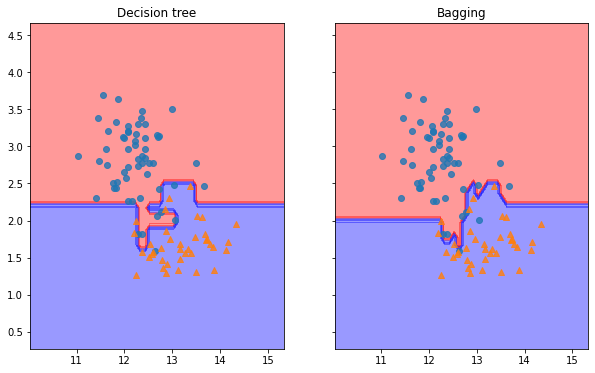

In [42]:
_, ax = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(10, 6))
for idx, clf, label in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    plot_decision_regions(X_train, y_train, clf, label, resolution=0.1,  ax= ax[idx])

# Adaptive Boosting [AdaBoost](https://neerc.ifmo.ru/wiki/index.php?title=Бустинг,_AdaBoost)
### Работа бустинга
> 1. Выбираем случайный поднабор без возвращения и обучаем слабого ученика $C_1$
> 2. Выбираем 2й случайный поднабор без возвращения и добавляем к нему 50% неправильно классифицирровнных образцов $C_1$, обучаем слабого ученика $C_2$
> 3. Выбираем образцы по которым $C_1 и С_2$ расходятся и обучаем слабого ученика $C_3$
> 4. Проводим мажоритарное голосование среди $C_{1-3}$ 

<img src='https://user-images.githubusercontent.com/54672403/82243536-7baf4300-9948-11ea-9f5f-333b25cc8624.png' width='400'>

In [43]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

In [44]:
print_accuracy_score([tree, ada], ['Decision tree', 'AdaBoost'])

Аккуратность работы:

train = 0.92, test = 0.875 (Decision tree)
train = 1.0, test = 0.917 (AdaBoost)


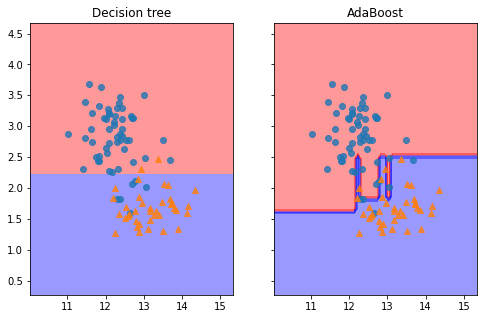

In [45]:
_, ax = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8, 5))
for idx, clf, label in zip([0, 1], [tree, ada], ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    plot_decision_regions(X_train, y_train, clf, label, resolution=0.1,  ax= ax[idx])